In [ ]:
import torch 
import torch.nn as nn

In [ ]:

class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Input: N x channels_noise x 1 x 1
            nn.ConvTranspose2d(channels_noise, features_g * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(features_g * 8),
            nn.ReLU(True),
            self._layer(features_g * 8, features_g * 4, 4, 2, 1),  #  8x8
            self._layer(features_g * 4, features_g * 2, 4, 2, 1),  #  16x16
            self._layer(features_g * 2, features_g , 4, 2, 1),  # 32x32

            nn.ConvTranspose2d(features_g , channels_img, 4, 2, 1, bias = False),
                                                        #  N x channels_img x 64 x 64
            nn.Tanh(),
        )

    def _layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            #  N x channels_img x 64 x 64
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # _layer(in_channels, out_channels, kernel_size, stride, padding)


            self._layer(features_d, features_d * 2, 4, 2, 1),
            self._layer(features_d * 2, features_d * 4, 4, 2, 1),
            self._layer(features_d * 4, features_d * 8, 4, 2, 1),
                                                                                   # _layer img output is 4x4 (Conv2d below makes into 1x1)
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _layer(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False,),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc(x)

In [5]:

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




LEARNING_RATE = 2e-4  
BATCH_SIZE = 16
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 600
FEATURES_DISC = 64  #64
FEATURES_GEN = 64  #64

transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(), transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)


dataset = datasets.ImageFolder(root="/content/textures", transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

step = 0

gen.train()
disc.train()

for epoch in range(NUM_EPOCHS):
    
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

   
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{NUM_EPOCHS}]  \ Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}")

            with torch.no_grad():
                fake = gen(fixed_noise)
      
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

         

            step += 1

Epoch [0/600] Batch 0/4                   Loss D: 0.7031, loss G: 0.7790
Epoch [1/600] Batch 0/4                   Loss D: 0.5455, loss G: 1.0285
Epoch [2/600] Batch 0/4                   Loss D: 0.4280, loss G: 1.2478
Epoch [3/600] Batch 0/4                   Loss D: 0.3335, loss G: 1.4542
Epoch [4/600] Batch 0/4                   Loss D: 0.2588, loss G: 1.6517
Epoch [5/600] Batch 0/4                   Loss D: 0.2184, loss G: 1.8308
Epoch [6/600] Batch 0/4                   Loss D: 0.1702, loss G: 2.0034
Epoch [7/600] Batch 0/4                   Loss D: 0.1373, loss G: 2.1721
Epoch [8/600] Batch 0/4                   Loss D: 0.1168, loss G: 2.3283
Epoch [9/600] Batch 0/4                   Loss D: 0.0952, loss G: 2.4811
Epoch [10/600] Batch 0/4                   Loss D: 0.0822, loss G: 2.6242
Epoch [11/600] Batch 0/4                   Loss D: 0.0711, loss G: 2.7645
Epoch [12/600] Batch 0/4                   Loss D: 0.0646, loss G: 2.8681
Epoch [13/600] Batch 0/4                   Loss 

In [17]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [18]:
!unzip "/content/drive/MyDrive/textures"

Archive:  /content/drive/MyDrive/textures.zip
   creating: textures/images/
  inflating: textures/images/01.jpg  
  inflating: textures/images/02.jpg  
  inflating: textures/images/03.jpg  
  inflating: textures/images/04.jpg  
  inflating: textures/images/05.jpg  
  inflating: textures/images/06.jpg  
  inflating: textures/images/07.jpg  
  inflating: textures/images/08.jpg  
  inflating: textures/images/09.jpg  
  inflating: textures/images/10.jpg  
  inflating: textures/images/11.jpg  
  inflating: textures/images/12.jpg  
  inflating: textures/images/13.jpg  
  inflating: textures/images/14.jpg  
  inflating: textures/images/15.jpg  
  inflating: textures/images/16.jpg  
  inflating: textures/images/17.jpg  
  inflating: textures/images/19.jpg  
  inflating: textures/images/20.jpg  
  inflating: textures/images/21.jpg  
  inflating: textures/images/22.jpg  
  inflating: textures/images/23.jpg  
  inflating: textures/images/24.jpg  
  inflating: textures/images/25.jpg  
  inflating:

In [ ]:
/content/drive/MyDrive/texture

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.pyplot as plt 

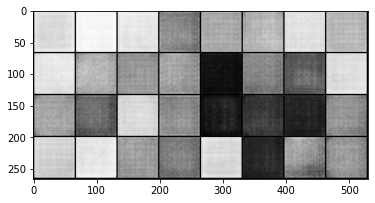

In [ ]:
plt.imshow(img_grid_fake.cpu().numpy()[0],cmap='gray')

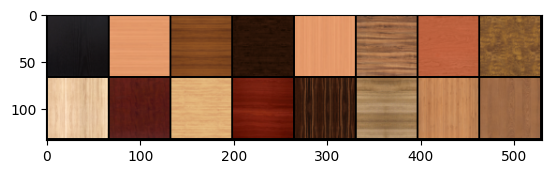

In [ ]:
plt.imshow(img_grid_real.cpu().numpy().transpose(1, 2, 0))

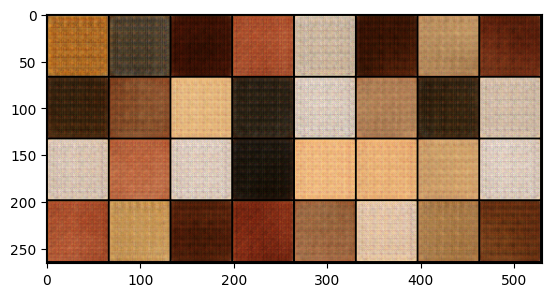

In [ ]:
plt.imshow(img_grid_fake.cpu().numpy().transpose(1, 2, 0))

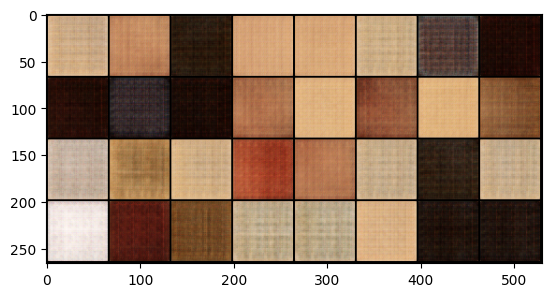

In [ ]:
plt.imshow(img_grid_fake.cpu().numpy().transpose(1, 2, 0))

In [ ]:
img = img_grid_fake.cpu().numpy().transpose(1, 2, 0)

In [ ]:
plt.imshow(img)

NameError: ignored

In [ ]:
img_grid_fake[1] 

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0107,  ..., 0.0070, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0046,  ..., 0.0024, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

TypeError: ignored

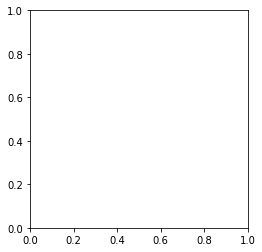

In [ ]:
plt.imshow(img_grid_fake)

In [ ]:
import matplotlib.pyplot as plt